In [10]:
! pip install cftime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 14.1 MB/s eta 0:00:00


In [12]:
import xarray as xr
import pandas as pd
import numpy as np
import cftime

print("xarray:", xr.__version__)
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("cftime:", cftime.__version__)

xarray: 2025.3.1
pandas: 2.2.2
numpy: 2.0.2
cftime: 1.6.4.post1


In [13]:
import xarray as xr

# === Paths to your files ===
# instant_file = "data_stream-oper_stepType-instant.nc"
accum_file = "c42def4b8d7ee5ccec8efc1e40f6b79d.nc"
pressure_file = "28b573196e2f7b216f818bdac74b6e52.nc"

# === Helper function to inspect a dataset ===
def inspect_dataset(path):
    print(f"\n📂 File: {path}")
    ds = xr.open_dataset(path, decode_times=False)
    print(f"🔸 Variables: {list(ds.data_vars)}")
    print(f"🧭 Coordinates: {list(ds.coords)}")
    print(f"📏 Dimensions: {dict(ds.sizes)}")

    # Use 'valid_time' or 'time' if available
    time_coord = 'valid_time' if 'valid_time' in ds.coords else 'time'
    if time_coord in ds.coords:
        print(f"🕓 Time range: {ds[time_coord].values[0]} → {ds[time_coord].values[-1]}")
    else:
        print("⚠️ No time coordinate found.")

    # Sample attributes
    for var in list(ds.data_vars)[:2]:
        print(f"\nℹ️ Variable: {var}")
        # print(ds[var])
        print(f"{var} - dims: {ds[var].dims}, shape: {ds[var].shape}, dtype: {ds[var].dtype}")

    return ds


# === Inspect each file ===
# ds_instant = inspect_dataset(instant_file)
ds_accum = inspect_dataset(accum_file)
ds_pressure = inspect_dataset(pressure_file)


📂 File: c42def4b8d7ee5ccec8efc1e40f6b79d.nc
🔸 Variables: ['ssrd']
🧭 Coordinates: ['number', 'valid_time', 'latitude', 'longitude', 'expver']
📏 Dimensions: {'valid_time': 168, 'latitude': 721, 'longitude': 1440}
🕓 Time range: 1625097600 → 1625698800

ℹ️ Variable: ssrd
ssrd - dims: ('valid_time', 'latitude', 'longitude'), shape: (168, 721, 1440), dtype: float32

📂 File: 28b573196e2f7b216f818bdac74b6e52.nc
🔸 Variables: ['cc', 'q', 't', 'u', 'v']
🧭 Coordinates: ['number', 'valid_time', 'pressure_level', 'latitude', 'longitude', 'expver']
📏 Dimensions: {'valid_time': 168, 'pressure_level': 1, 'latitude': 721, 'longitude': 1440}
🕓 Time range: 1625097600 → 1625698800

ℹ️ Variable: cc
cc - dims: ('valid_time', 'pressure_level', 'latitude', 'longitude'), shape: (168, 1, 721, 1440), dtype: float32

ℹ️ Variable: q
q - dims: ('valid_time', 'pressure_level', 'latitude', 'longitude'), shape: (168, 1, 721, 1440), dtype: float32


In [16]:
# List of solar site metadata
SOLAR_FIELDS = [
    {"name": "Bhadla", "lat": 27.5833, "lon": 71.4333},
    {"name": "Tengger", "lat": 37.3333, "lon": 103.8558},
    {"name": "Benban", "lat": 24.5561, "lon": 32.9016},
    {"name": "Cestas", "lat": 44.7255, "lon": -0.8157},
    {"name": "Balboa", "lat": 38.4533, "lon": -6.2260},
    {"name": "Topaz", "lat": 35.2426, "lon": -120.0096},
    {"name": "DesertSun", "lat": 33.8214, "lon": -115.3939},
    {"name": "Pirapora", "lat": -17.0891, "lon": -44.9878},
    {"name": "Nyngan", "lat": -31.5575, "lon": 147.2031},
]

def extract_site_data(ds, var_list, site, pressure_level=None):
    """Extracts data for a given site from an xarray dataset."""
    lat = site["lat"]
    lon = site["lon"] % 360  # convert to 0-360 if needed
    site_name = site["name"]

    ds_site = ds.sel(latitude=lat, longitude=lon, method="nearest")

    if pressure_level:
        ds_site = ds_site.sel(pressure_level=pressure_level)

    df = ds_site[var_list].to_dataframe().reset_index()
    df["site"] = site_name
    df["latitude"] = lat
    df["longitude"] = lon
    return df


# Load datasets
# ds_instant = xr.open_dataset("data_stream-oper_stepType-instant.nc")
ds_accum = xr.open_dataset(accum_file)
ds_pressure = xr.open_dataset(pressure_file)

# Variables to extract
# INSTANT_VARS = ["t2m", "tcc"]
ACCUM_VARS = ["ssrd"]
PRESSURE_VARS = ["q", "t", "cc", "u", "v"]

# Extract for all sites
dfs = []
for site in SOLAR_FIELDS:
    # df1 = extract_site_data(ds_instant, INSTANT_VARS, site)
    df2 = extract_site_data(ds_accum, ACCUM_VARS, site)
    df3 = extract_site_data(ds_pressure, PRESSURE_VARS, site, pressure_level=500)

    df_site = df2.merge(df3, on=["valid_time", "site"], how="outer")
    # df_site = df_site.merge(df3, on=["valid_time", "site"], how="outer")
    dfs.append(df_site)

# Concatenate all sites
df_all_sites = pd.concat(dfs)

# Optional: convert temperature from K to °C
# df_all_sites["t2m"] = df_all_sites["t2m"] - 273.15
df_all_sites["t"] = df_all_sites["t"] - 273.15

# Save
df_all_sites.to_csv("era5_features_sites_long.csv", index=False)
print("✅ Extracted site-level ERA5 features!")

✅ Extracted site-level ERA5 features!


In [25]:
import xarray as xr
import pandas as pd
import numpy as np

# === Step 1: Load the saved ERA5 feature file ===
df = pd.read_csv("era5_features_sites_long.csv", parse_dates=["valid_time"])

# === Step 2: Extract one site (e.g., "Bhadla") ===
site_name = "Bhadla"
df_site = df[df["site"] == site_name].copy()
df_site = df_site.sort_values("valid_time")

# === Step 3: Convert accumulated ssrd (J/m²) to irradiance (W/m²) ===
df_site["ssrd_irradiance"] = df_site["ssrd"].diff() / 3600.0  # Assuming hourly
df_site["ssrd_irradiance"] = df_site["ssrd_irradiance"].clip(lower=0)
df_site = df_site.dropna(subset=["ssrd_irradiance"])  # Drop first NaN

# === Step 4: Create the target as next-hour irradiance (t+1) ===
df_site["target"] = df_site["ssrd_irradiance"].shift(-1)
df_site = df_site.dropna(subset=["target"])  # Drop last row with NaN target

# Filter where next-hour irradiance (target) is greater than 0
df_site = df_site[df_site["target"] > 0]

# Add temporal features
df_site["hour"] = df_site["valid_time"].dt.hour
df_site["dayofyear"] = df_site["valid_time"].dt.dayofyear

# Add to features
feature_cols = ["q", "t", "cc", "u", "v", "hour", "dayofyear"]
X = df_site[feature_cols].copy()

# === Step 5: Define features X and target y ===
# # Drop unneeded columns
# feature_cols = ["q", "t", "cc", "u", "v"]  # your predictors
# X = df_site[feature_cols].copy()
y = df_site["target"].copy()

print("✅ Prepared data shapes:")
print("X:", X.shape)
print("y:", y.shape)


✅ Prepared data shapes:
X: (55, 7)
y: (55,)


In [26]:
print(y.describe())

count     55.000000
mean     118.087434
std       68.055346
min        9.902222
25%       77.315556
50%      134.044444
75%      182.320000
max      207.644444
Name: target, dtype: float64


✅ RMSE: 2.64 W/m²
✅ R² Score: 0.998


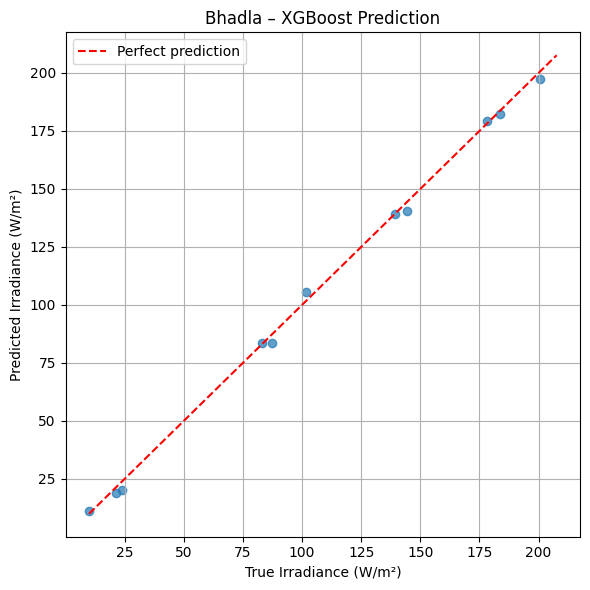

In [27]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# === Step 1: Train/test split ===
# Determine the index to split (e.g., last 20% for test)
split_idx = int(len(X) * 0.8)

# Time-based split: earlier 80% for training, later 20% for testing
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# === Step 2: Train XGBoost regressor ===
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    objective="reg:squarederror",
    random_state=42
)
model.fit(X_train, y_train)

# === Step 3: Predict and evaluate ===
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"✅ RMSE: {rmse:.2f} W/m²")
print(f"✅ R² Score: {r2:.3f}")

# === Step 4: Plot actual vs predicted ===
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label="Perfect prediction")
plt.xlabel("True Irradiance (W/m²)")
plt.ylabel("Predicted Irradiance (W/m²)")
plt.title(f"{site_name} – XGBoost Prediction")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [34]:
print(X_train.shape)

(44, 7)


<Figure size 800x600 with 0 Axes>

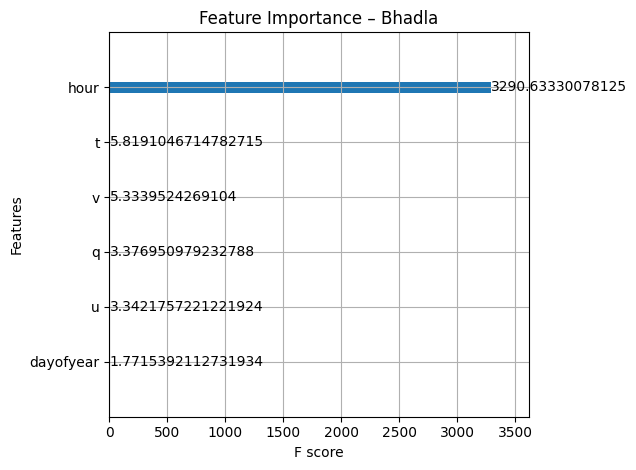

In [29]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plot_importance(model, importance_type="gain")  # can use "weight", "gain", or "cover"
plt.title(f"Feature Importance – {site_name}")
plt.tight_layout()
plt.show()


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 16060.9365 - val_loss: 30987.2461
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 17029.0918 - val_loss: 30969.9082
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 17888.5078 - val_loss: 30950.2129
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 16995.7285 - val_loss: 30933.3145
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 16588.5703 - val_loss: 30912.6113
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 14612.2070 - val_loss: 30880.7539
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 16286.7441 - val_loss: 30845.3633
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 14178.6904 - val_loss: 30793.4004
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 18658.0957 - val_loss: 30717.5176
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 15939.1611 - val_loss: 30602.8223
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 14765.5615 - val_loss: 30444.613

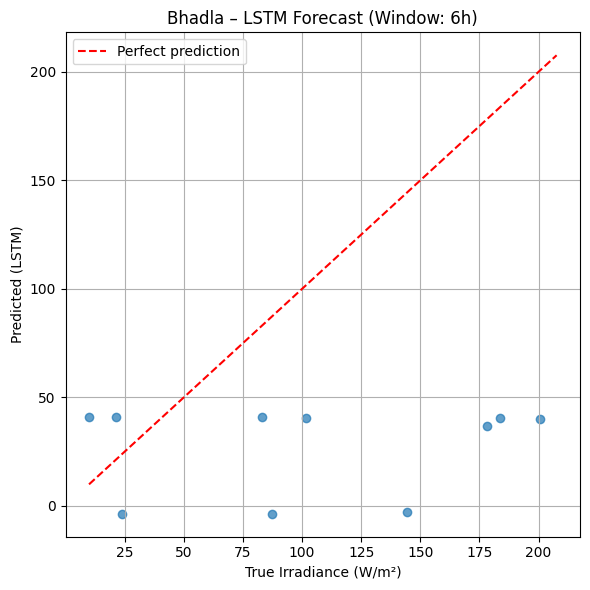

In [32]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# === Step 1: Scale entire feature set before creating sequences ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Step 2: Create sequences of past N hours ===
def create_sequences(X_data, y_data, window_size):
    X_seq, y_seq = [], []
    for i in range(len(X_data) - window_size):
        X_seq.append(X_data[i:i+window_size])
        y_seq.append(y_data[i+window_size])
    return np.array(X_seq), np.array(y_seq)

window_size = 6  # Use last 6 hours as input
X_seq, y_seq = create_sequences(X_scaled, y.values, window_size)

# === Step 3: Time-based split for training/testing ===
split_idx = int(len(X_seq) * 0.8)
X_train_lstm, X_test_lstm = X_seq[:split_idx], X_seq[split_idx:]
y_train_lstm, y_test_lstm = y_seq[:split_idx], y_seq[split_idx:]

# === Step 4: Build LSTM model ===
model_lstm = Sequential([
    LSTM(64, input_shape=(window_size, X.shape[1]), return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')

# === Step 5: Train model ===
history = model_lstm.fit(
    X_train_lstm, y_train_lstm,
    epochs=100,
    batch_size=8,
    validation_split=0.1,
    verbose=1  # set to 0 if you prefer quiet training
)

# === Step 6: Evaluate ===
y_pred_lstm = model_lstm.predict(X_test_lstm).flatten()
rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm, y_pred_lstm))
r2_lstm = r2_score(y_test_lstm, y_pred_lstm)

print(f"✅ LSTM RMSE: {rmse_lstm:.2f} W/m²")
print(f"✅ LSTM R² Score: {r2_lstm:.3f}")

# === Step 7: Visualization ===
plt.figure(figsize=(6, 6))
plt.scatter(y_test_lstm, y_pred_lstm, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label="Perfect prediction")
plt.xlabel("True Irradiance (W/m²)")
plt.ylabel("Predicted (LSTM)")
plt.title(f"{site_name} – LSTM Forecast (Window: {window_size}h)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
print("Training samples:", X_train_lstm.shape[0])


Training samples: 39
